In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  22160      0 --:--:-- --:--:-- --:--:-- 22019


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing openmm, pdbfixer
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [3]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 1.4 MB/s 


In [4]:
#모든 모듈 리로드
%load_ext autoreload
%autoreload 2

In [5]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [7]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing
ZINC.smiles 파일에 text로 표현되어 있는 분자들을 molecular graph 형태로 바꿔줍시다. 이때 node feature matrix는 아래 그림과 같이 각 원자의 symbol, degree 등 화학적 특성을 one-hot vector로 나타낸 형태임
read_ZINC_smiles 함수는 smiles 파일 내의 분자 텍스트의 list와 각 분자들의 실제 logP value list를 return합니다. convert_to_graph 함수는 분자 텍스트의 list를 받아 각 분자들의 node feature matrix list와 adjacency matrix list를 return 함
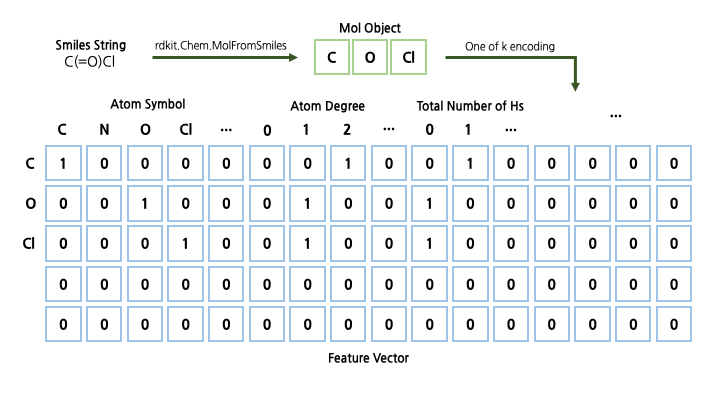

In [8]:
!curl -o ZINC.smiles https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/ZINC.smiles
!curl -o vocab.npy https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/vocab.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5374k  100 5374k    0     0  12.3M      0 --:--:-- --:--:-- --:--:-- 12.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256  100   256    0     0    934      0 --:--:-- --:--:-- --:--:--   934


In [9]:
#ZINC SMILES와 logP의 값을 읽어오는 코드
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list

#SMILES를 원핫 인코딩으로 만드는 과정 이코드에서 사용하지 x
def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " " 
        vector = [vocab.index(str(x)) for x in smiles]
        #vocab의 크기를 구했으면
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

#SMILES를 그래프 데이터로 전환
def convert_to_graph(smiles_list):
    adj = [] #인접행렬
    adj_norm = []
    features = [] #feature matrix
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

#커스텀 데이터셋 구성
#input2개 output1개
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]

#데이터를 자르는 작업
def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [10]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 100)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Reading Data:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Converting to Graph:   0%|          | 0/100 [00:00<?, ?it/s]

# 2. Model Construction
Graph Convolution Network, 즉 GCN을 pytorch를 이용하여 구현해보자.
이를 위해 다음과 같은 sub module들을 구현하고 사용함

__GCNLayer__: node feature matrix와 adjacency matrix의 list를 받아 graph convolution 연산을 수행하는 module 임

__(Gated)SkipConnection__: ResNet에서 사용되었던 skip connection technique을 구현한 module 임

__GCNBlock__: node feature matrix와 adjacency matrix의 list를 받아 원하는 갯수의 GCNLayer를 통과시킨 후, (gated)skip connection을 적용하는 module 임

__ReadOut__: graph structrure에 permutation invariance를 주기 위하여 linear layer를 거친 뒤 batch 별로 summation하는 module 임

__Predictor__: ReadOut layer로부터의 graph feature vector로부터 logP value를 예측하기 위한 linear layer module 임
위 모듈들을 사용하여 GCNNet을 구현해보자.

In [11]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x): #in_x는 아무것도 거치지않은 x, out_x는 연산을 거치고난 x
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [12]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [13]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [14]:
class GCNLayer(nn.Module):
    # h_l+1 = activation(A* h_l * W + b)
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim) #W*input
        nn.init.xavier_uniform_(self.linear.weight)#Xavier 초기화
        self.bn = nn.BatchNorm1d(n_atom) #1D batch_normal

        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x) #h_l*W
        if self.use_atn:
            out = self.attention(out, adj) 
        else:
            out = torch.matmul(adj, out)# matrix multiplication  A* h_l * W
        if self.use_bn: 
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [15]:
class GCNBlock(nn.Module): 
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()# 반복적으로 레이어를 쌓는 함수
        for i in range(n_layer):
            #반복적으로 쌓는데 첫번째 레이어는 input_dim을 사용할 수 있으나 이후에는 hidden_dim 차원으로 입력을 받아야함
            #마찬가지로 마지막 레이어에서는 out_dim 사이즈로 고정해줘야함
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None, #마지막에은 activation 안함 이유는 skip-connect이후에 activation 해줄것
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        #skip-connect
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [16]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        #가장 간단한 readout으로 MLP사용
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [17]:
class Predictor(nn.Module):
    #단순히 FC레이어 만들어서 activation해주는 역할
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [18]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [19]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_logP = torch.tensor(batch[2]).to(device).float()
        list_logP = list_logP.view(-1,1)
                
        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [20]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_feature, list_adj)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [21]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
        
    return mae, std, logP_total, pred_logP_total

In [22]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [23]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [24]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    

In [25]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [26]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiment

In this experiment, hyperparamter tunning will be done to find the best hyperparameter set for the __GCN__ model with __(gated) skip conenction__ and __attention__.

# 5.1 Experiment 1. lr vs n_block

In [27]:
args.batch_size = 1024
args.lr = 0.0001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 2
args.n_atom = 50
args.in_dim = 58
args.num_head = 2
args.dropout=0.2
args.hidden_dim = 64
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
list_lr = [0.01, 0.001, 0.0001, 0.00001]
list_n_block = [1, 2, 3]
#list_lr = [0.001]
#list_n_block = [2]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 50000.JSON', orient='table')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/32400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

lr:0.01/n_block:1 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.01/n_block:2 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.01/n_block:3 took 2seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.001/n_block:1 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.001/n_block:2 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.001/n_block:3 took 2seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.0001/n_block:1 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.0001/n_block:2 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:0.0001/n_block:3 took 2seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:1e-05/n_block:1 took 1seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-

lr:1e-05/n_block:2 took 1seconds.
lr:1e-05/n_block:3 took 2seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


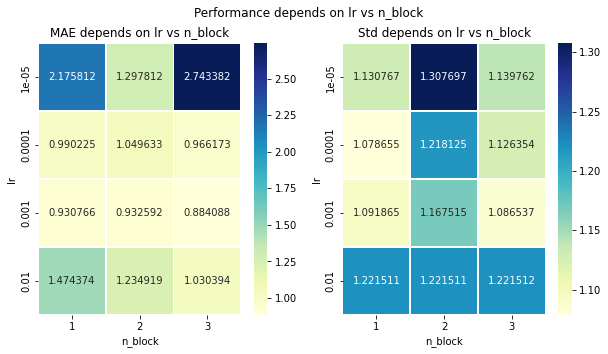

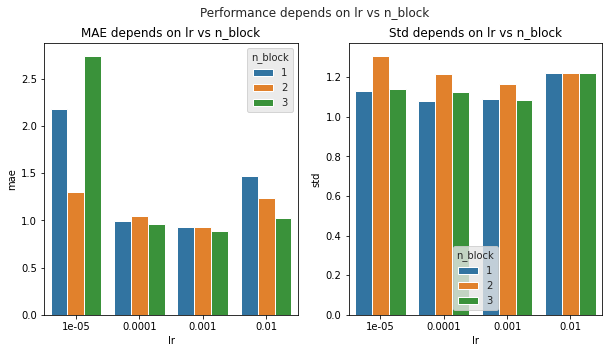

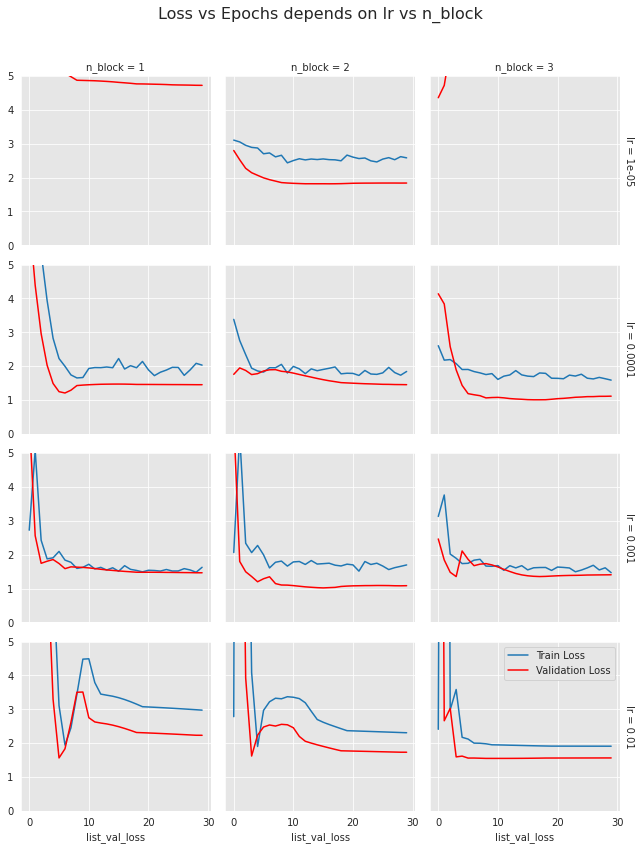

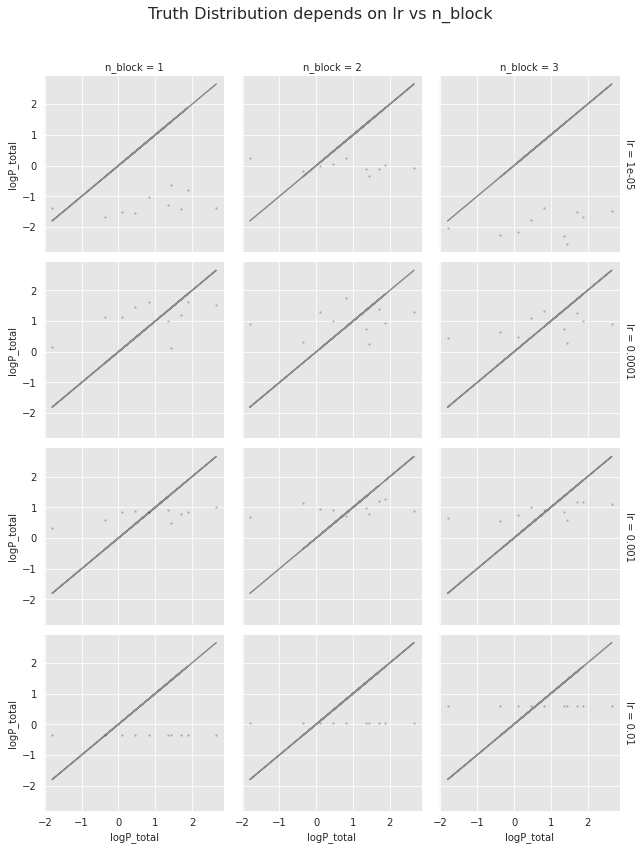

In [29]:
df_result = pd.read_json('lr vs n_block 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 5)
plot_distribution(df_result, var1, var2)

## Experiment 1. lr vs n_block
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __learning rate (lr)__ and __number of Skip Connection Block (n_block)__ used in the each model.

The learning rate was chose to be the first hyperparameters to be tuned because if we find the best learning rate, no matter what the model architecture is, we can use that learning rate to future exepriemnts. Thus, the number of block, which effetcs the model architecture the most, was chose to be the second.
#### Variable Domain
- __lr__ : [0.01, 0.001, 0.0001, 0.00001]
- __n_block__ : [1, 2, 3]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- Learning rate of 0.001 showed the best performance.
- There was no notable tendency between the learning rate and the number of GCN blocks.
- No overfitting occured, but the models did not leanred with learning rate of 0.01.
- Time spent for training each model was not that different depending on the number of GCN blocks.

#### Discussion
- Even though there are other parameters that defines a model, such as n_layer, usage of (gated) skip connection, etc, I assumed that n_block is the most important model-defining parameter. Since learning rate of 0.001 showed the best result irrespective of n_block, I concluded that 0.001 is the optimal learning rate of all of my models.
- Model learned nothing with learning rate of 0.01. This is because the step of opimizer is too big to reach a local minimum.
- As n_block increases, time spent on training increased, but not quite 

After this experiment, the learning rate and the number of GCN blocks were fixed to 0.001 and 3, which shoed the best performance.

# 6. Best Model
In this expeirment, the model with tunned hyperparamter set will be trained by 190000 data with 100 epochs to get the best performance with CNN model.

In [33]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 5000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Reading Data:   0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Converting to Graph:   0%|          | 0/5000 [00:00<?, ?it/s]

In [34]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0.2
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/450000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

In [36]:
df_result['list_train_loss']

result 190000    [1.8246018767356873, 1.2969790622591972, 1.101...
Name: list_train_loss, dtype: object

MAE: 0.2109341076
Std: 0.2608661795


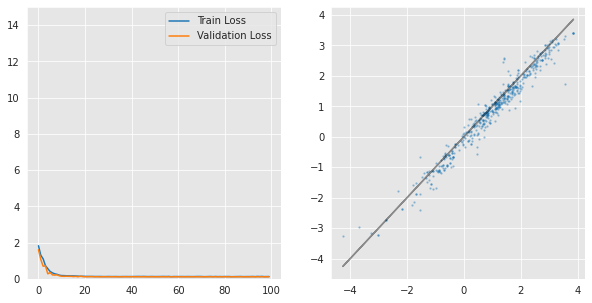

In [37]:
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 15])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)

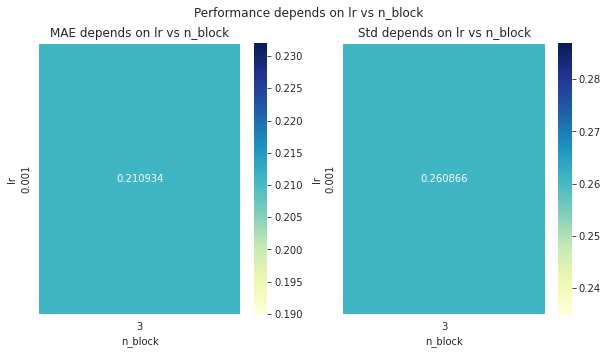

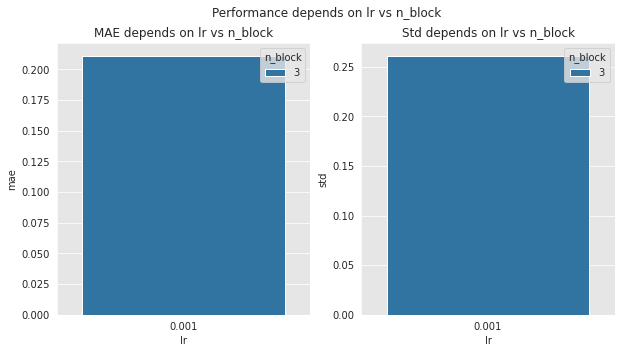

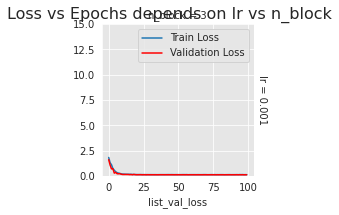

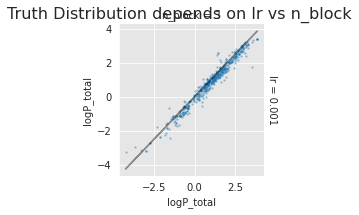

In [38]:
df_result = pd.read_json('result 190000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 15)
plot_distribution(df_result, var1, var2)